In [1]:
import numpy as np


def test(x, w_multi):
    result_matrix = x.dot(w_multi.T)
    x["preds"] = result_matrix.apply(np.argmax, axis=1)


def train(x_train, y_train_onehot, max_iterations):
    # init weights vector for all classes
    best_w_multi = np.random.uniform(0, 0, (10, 785))

    # for each class, add label '1' if the example belongs to the class, else '-1'
    y_train_onehot_labels = y_train_onehot.apply(lambda col: col * 2 - 1)

    # train each class separately
    for i in range(10):
        best_w = w = best_w_multi[i]
        min_error = get_errors(x_train, y_train_onehot_labels.iloc[:, i], w)

        for epoch in range(max_iterations):
            is_misclassified, w = run_pla(x_train, y_train_onehot_labels.iloc[:, i], w)

            if is_misclassified:
                errors_w = get_errors(x_train, y_train_onehot_labels.iloc[:, i], w)

                # save pocket
                if errors_w < min_error:
                    best_w = w
                    min_error = errors_w
            else:
                best_w_multi[i] = w
                break

        best_w_multi[i] = best_w

    return best_w_multi


def get_errors(x_train, y_train_onehot_labels, w):
    all_preds = np.sign(np.dot(x_train.values, w))
    return np.sum(all_preds != y_train_onehot_labels)


def run_pla(x, y, w):
    is_misclassified, idx = get_misclassified_idx(x, y, w)

    if is_misclassified:
        xt, yt = get_xt_yt(x, y, idx)

        # predict for single class
        pred = np.sign(np.inner(xt, w))
        if yt != pred:
            w = w + yt * np.array(xt)

    return is_misclassified, w


def get_misclassified_idx(x_train, y_train_onehot_labels, w):
    all_preds = np.sign(np.dot(x_train.values, w))
    row_indices = np.where(all_preds != y_train_onehot_labels)

    if len(row_indices) != 0:
        return True, row_indices[0][0]
    else:
        return False, -1


def get_xt_yt(x, y, idx):
    # extract x(t)
    xrow = x.iloc[idx]
    y_idx = xrow.name
    xt = xrow.tolist()

    # extract y(t)
    yt = int(y.get(y_idx))

    return xt, yt


Starting perceptron


C:\GitRepos\IntroToML\venv\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\stav5\AppData\Local\Temp\ipykernel_20608\2699756956.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_train.insert(0, 'Bias', 1)
C:\Users\stav5\AppData\Local\Temp\ipykernel_20608\2699756956.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

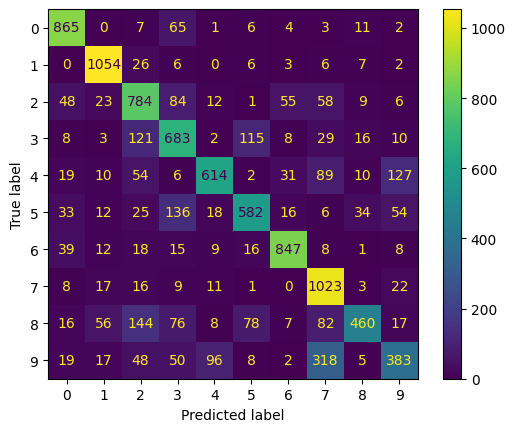

accuracy: 0.7295
Sensitivity for each class:
Class 0: 0.90
Class 1: 0.95
Class 2: 0.73
Class 3: 0.69
Class 4: 0.64
Class 5: 0.64
Class 6: 0.87
Class 7: 0.92
Class 8: 0.49
Class 9: 0.40


In [2]:
# This is a sample Python script.

# Press ⌃R to execute it or replace it with your code.
# Press Double ⇧ to search everywhere for classes, files, tool windows, actions, and settings.
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np


def run_perceptron():
    print(f'Starting perceptron')

    # Fetch MNIST dataset
    mnist = fetch_openml('mnist_784')

    # Extract features (x) and labels (y)
    x, y = mnist.data, mnist.target

    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000)
    y_train_onehot = pd.get_dummies(y_train.astype(int)).astype(int)

    # Add bias
    x_train.insert(0, 'Bias', 1)
    x_test.insert(0, 'Bias', 1)

    w = train(x_train, y_train_onehot, 50)
    test(x_test, w)
    actual = y_test.astype(int)
    preds = x_test["preds"]

    # generate confusion matrix
    test_cmatrix = confusion_matrix(actual, preds)
    test_display = ConfusionMatrixDisplay(test_cmatrix)
    test_display.plot()
    plt.savefig('confusion_matrix.png')

    plt.show()

    print(f'accuracy: {accuracy_score(actual, preds)}')

    sensitivity_per_class = []

    for i in range(10):
        true_positives = test_cmatrix[i, i]
        false_negatives = sum(test_cmatrix[i, :]) - true_positives
        sensitivity = true_positives / (true_positives + false_negatives)
        sensitivity_per_class.append(sensitivity)

    print("Sensitivity for each class:")
    for i, sensitivity in enumerate(sensitivity_per_class):
        print(f"Class {i}: {sensitivity:.2f}")


run_perceptron()

